# Sistem de fuziune a deciziilor prin ponderare

In [5]:
from FusionSystem import *
import torch
import torch.optim as optim
import torch.nn as nn
from SegDataset import *
from utils.function_lib import *
from utils.DiceLoss import DiceLoss
from tqdm import tqdm

In [6]:
training_path = 'G:/MachineLearning/liver-database/validation/processed/'

training_dataset = SegDataset(training_path)
training_dataloader = torch.utils.data.DataLoader(training_dataset, batch_size=16, shuffle=False, num_workers=4, pin_memory=True)

device = torch.device('cpu')
fusion_model = FusionSystem(num_sources=4).to(device)
optimizer = optim.SGD(fusion_model.parameters() ,lr=10, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.9)
loss_fcn = nn.BCEWithLogitsLoss().to(device)
checkpoint = torch.load('G:/MachineLearning/models/Fusion/Fusion_checkpoint.pt')
fusion_model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [7]:
for epoch in range(5):
    train_loop(training_dataloader, fusion_model, loss_fcn, optimizer, scheduler=None,  device=device)
    loss = test_loop(training_dataloader, fusion_model, loss_fcn, device=device)
    scheduler.step()

loss: 0.000552  [    0/ 4776]
loss: 0.034667  [ 1600/ 4776]
loss: 0.000658  [ 3200/ 4776]
Avg loss: 0.008287 

loss: 0.000402  [    0/ 4776]
loss: 0.034835  [ 1600/ 4776]
loss: 0.000963  [ 3200/ 4776]
Avg loss: 0.008445 

loss: 0.000272  [    0/ 4776]
loss: 0.035312  [ 1600/ 4776]
loss: 0.001285  [ 3200/ 4776]
Avg loss: 0.008468 

loss: 0.000259  [    0/ 4776]
loss: 0.035337  [ 1600/ 4776]
loss: 0.001292  [ 3200/ 4776]
Avg loss: 0.008468 

loss: 0.000259  [    0/ 4776]
loss: 0.035334  [ 1600/ 4776]
loss: 0.001292  [ 3200/ 4776]
Avg loss: 0.008468 



In [8]:
torch.save({
                'model_state_dict': fusion_model.state_dict()
            }, 'G:/MachineLearning/models/Fusion/Fusion_checkpoint.pt')

tensor([[[[0.2046]],

         [[0.2265]],

         [[0.2963]],

         [[0.2726]]]], grad_fn=<DivBackward0>)
DenseNet201
Inception
ResNet152
ResNeXt101
torch.Size([512, 512])
tensor(1.)


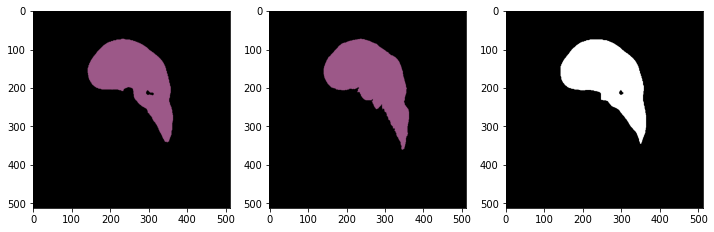

In [9]:
print(fusion_model.weights.weight / torch.sum(fusion_model.weights.weight))
show_model_seg(fusion_model.cpu(), training_dataset, 60)

## Salvam segementarile din sistemul de fuziune

In [4]:
fusion_model.eval()
iter = 0
with torch.no_grad():
    imagesize = 0
    for X, Y in tqdm(training_dataloader):
        imagesize = torch.numel(Y)
        pred = fusion_model(X.to(device))
        final_func = nn.Sigmoid()
        pred = final_func(pred)
        pred = torch.nn.functional.interpolate(pred, size=512, mode="bilinear", align_corners=False).squeeze()
        pred = torch.round(pred)
        for i in range(pred.size(dim = 0)):
            slc = pred[i, :, :]
            slc = slc.cpu().numpy()
            slc.astype(np.int8).tofile('G:/MachineLearning/liver-database/validation/Fusion/output' + ("-%04d.ct" % iter))
            iter = iter + 1

100%|██████████| 299/299 [01:21<00:00,  3.69it/s]
